In [5]:
import pandas as pd
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import decomposition, preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, silhouette_score, adjusted_rand_score

import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

import scipy.stats as stats
from scipy.stats import t, shapiro

import joblib

### Exploration des données

In [6]:
billets = pd.read_csv('billets.csv', sep=';')

In [7]:
billets

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54
...,...,...,...,...,...,...,...
1495,False,171.75,104.38,104.17,4.42,3.09,111.28
1496,False,172.19,104.63,104.44,5.27,3.37,110.97
1497,False,171.80,104.01,104.12,5.51,3.36,111.95
1498,False,172.06,104.28,104.06,5.17,3.46,112.25


In [8]:
billets.describe().round(2)

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.00,1500.00,1500.00,1463.00,1500.00,1500.00
mean,171.96,104.03,103.92,4.49,3.15,112.68
std,0.31,0.30,0.33,0.66,0.23,0.87
min,171.04,103.14,102.82,2.98,2.27,109.49
25%,171.75,103.82,103.71,4.01,2.99,112.03
50%,171.96,104.04,103.92,4.31,3.14,112.96
75%,172.17,104.23,104.15,4.87,3.31,113.34
max,173.01,104.88,104.95,6.90,3.91,114.44


In [9]:
print('Dans notre dataframe de paramétrisation comporte',len(billets.loc[billets['is_genuine'] == True,:]),'vrais billets et',len(billets.loc[billets['is_genuine'] == False,:]),'faux billets')


Dans notre dataframe de paramétrisation comporte 1000 vrais billets et 500 faux billets


Dans un premier temps nous allons réaliser un certain nombre d'affichage sur nos données afin de mieux en comprendre la nature : 

Voyons dans un premier temps les relations par paires de nos variables a l'aide d'un pariplot : 

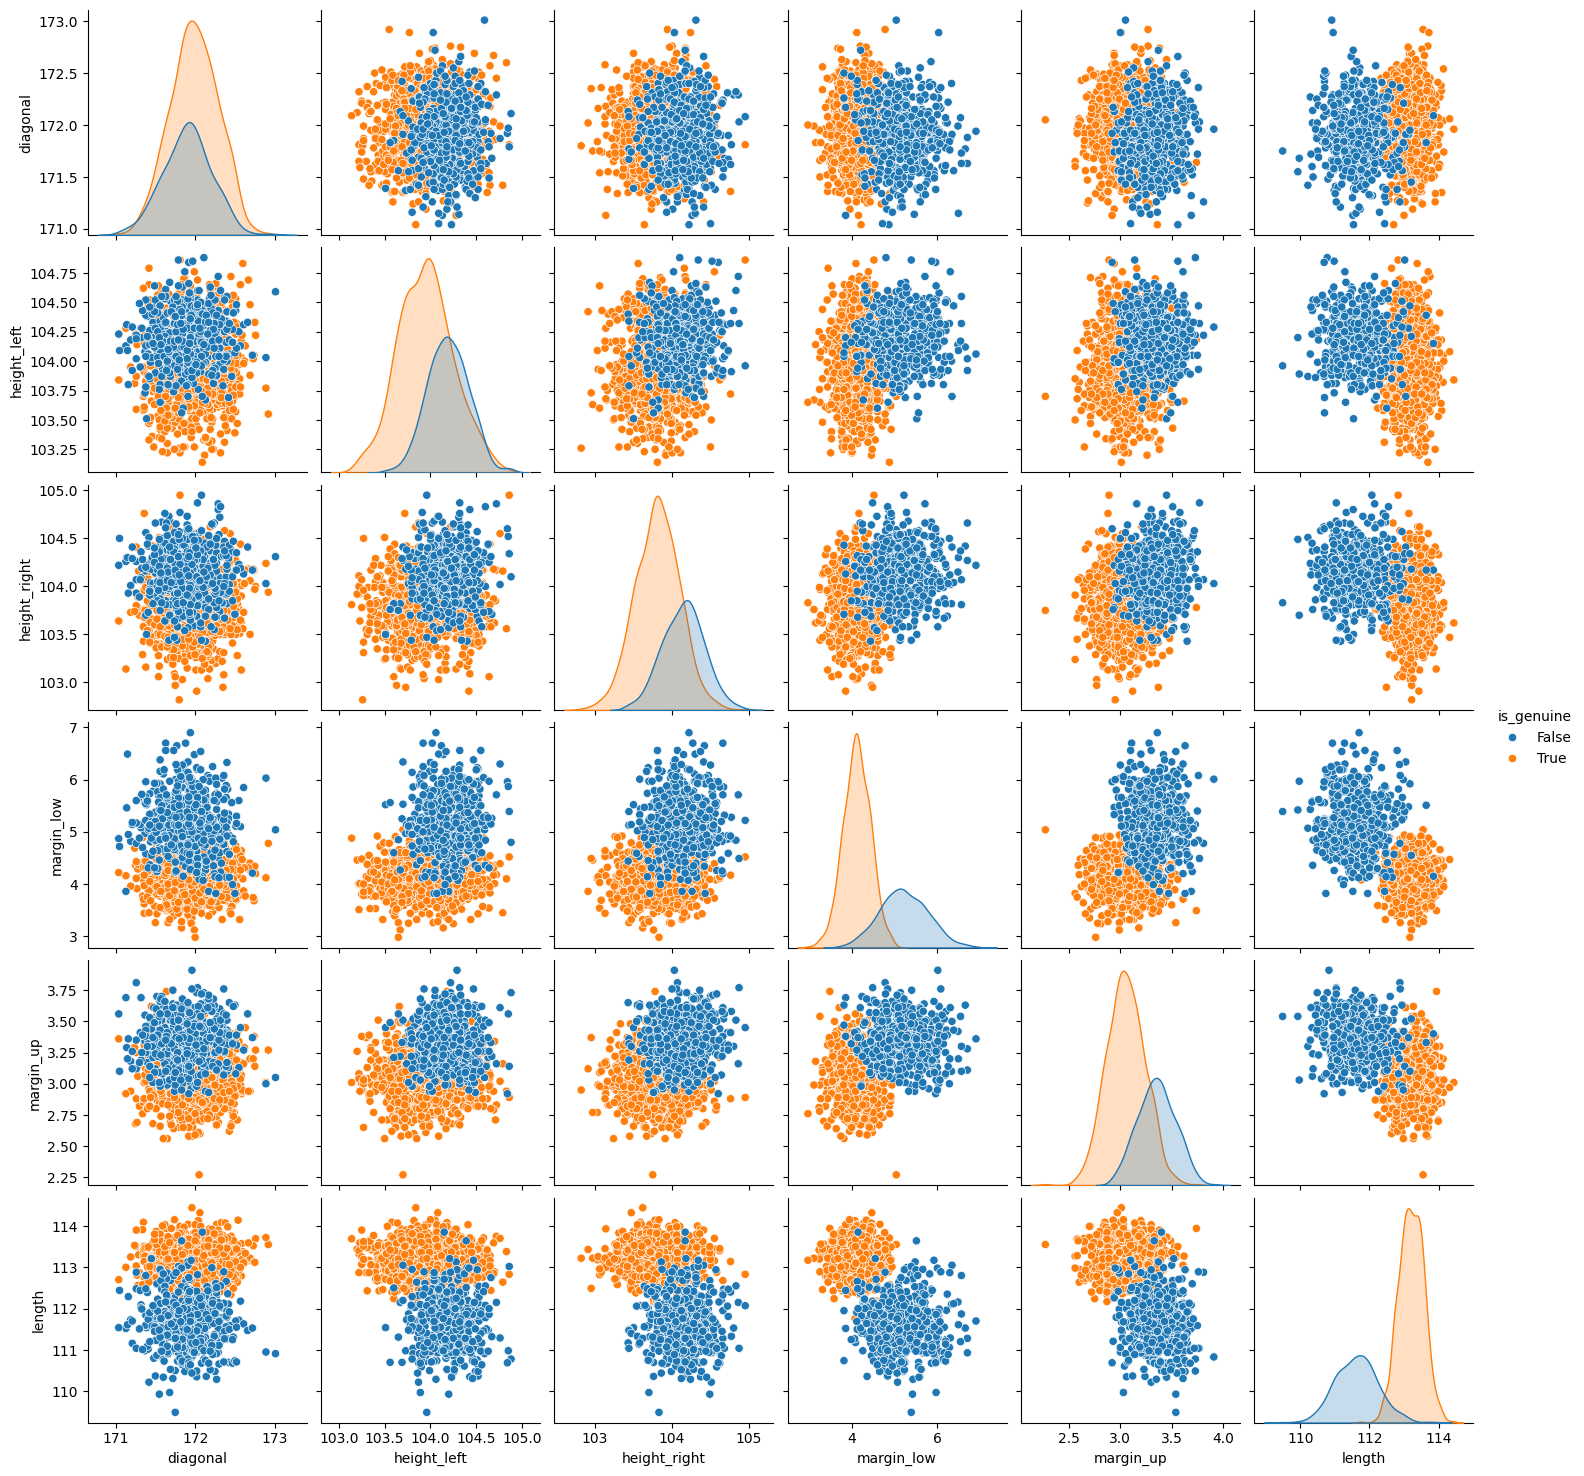

In [10]:
sns.pairplot(billets, hue='is_genuine')

On constate visuellement une certaine demarquation entre nos individus en fonction de leur label de vrai ou faux billet sur chacunes des paires plotées 

Observons ensuite la distribution de nos variables : 

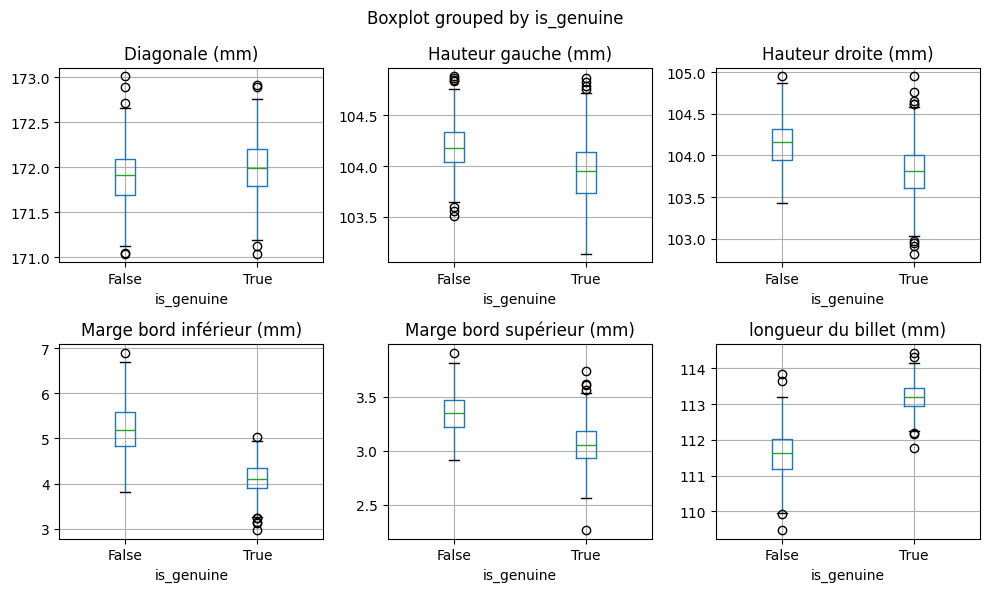

In [11]:
fig, axs = plt.subplots(2, 3,figsize=(10, 6))

billets.boxplot(column='diagonal',by='is_genuine', ax=axs[0, 0])
axs[0, 0].set_title('Diagonale (mm)')

billets.boxplot(column='height_left',by='is_genuine', ax=axs[0, 1])
axs[0, 1].set_title('Hauteur gauche (mm)')

billets.boxplot(column='height_right', by='is_genuine', ax=axs[0, 2])
axs[0, 2].set_title('Hauteur droite (mm)')

billets.boxplot(column='margin_low',by='is_genuine', ax=axs[1, 0])
axs[1, 0].set_title('Marge bord inférieur (mm)')

billets.boxplot(column='margin_up',by='is_genuine', ax=axs[1, 1])
axs[1, 1].set_title('Marge bord supérieur (mm)')

billets.boxplot(column='length',by='is_genuine', ax=axs[1, 2])
axs[1, 2].set_title('longueur du billet (mm)')

plt.tight_layout()
plt.show()

On constate visuellement des différences assez marquées entre nos les distributions de nos groupes de vrais et de faux billets sur l'ensemble de nos dimensions.

On va également venir analyser les corrélations de nos variables :

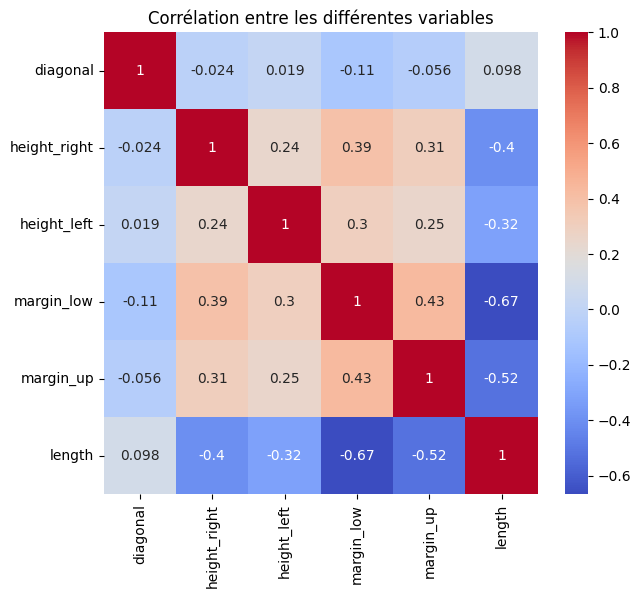

In [12]:
Kpi_corr = plt.figure(figsize=(7, 6))
Kpi_corr = sns.heatmap(billets[['diagonal','height_right', 'height_left','margin_low', 'margin_up', 'length']].corr(),cmap="coolwarm",annot=True)
Kpi_corr = plt.title('Corrélation entre les différentes variables')
Kpi_corr = plt.savefig('CORRELATION DES VARIABLES ENTRE ELLES.jpg')
plt.show(Kpi_corr)

Les deux corrrélations les plus prononcées de notre matrices sont négatives :

- Entre la variable de longueur et la variable de marge inférieur (-0,67)

- Entre la variable de longueur et la variable de marge supérieur (-0,52)

#### Création de plusieurs dataframes

On va créer deux nouveaux DF : 

- Un pour stocker les vrais billets

- Un pour stocker les faux billets

- Un pour stocker l'ensemble des billets sans la mention 'is_genuine'

In [13]:
vrai_billets = billets.loc[billets['is_genuine'] == True,:]
vrai_billets

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54
...,...,...,...,...,...,...,...
995,True,171.66,103.92,103.47,4.26,2.83,113.20
996,True,172.16,103.72,103.61,4.30,2.72,113.51
997,True,171.78,103.38,104.22,4.23,3.07,113.77
998,True,171.44,103.96,103.92,3.68,2.89,113.21


In [14]:
faux_billets = billets.loc[billets['is_genuine'] == False,:]
faux_billets

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
1000,False,172.28,103.95,103.91,4.78,3.31,111.40
1001,False,171.92,103.86,104.30,4.96,3.13,111.29
1002,False,171.59,104.14,104.38,4.97,3.47,111.22
1003,False,172.02,104.33,104.33,5.19,3.21,111.99
1004,False,172.55,104.25,104.23,5.60,3.13,111.72
...,...,...,...,...,...,...,...
1495,False,171.75,104.38,104.17,4.42,3.09,111.28
1496,False,172.19,104.63,104.44,5.27,3.37,110.97
1497,False,171.80,104.01,104.12,5.51,3.36,111.95
1498,False,172.06,104.28,104.06,5.17,3.46,112.25


In [15]:
billets_v2 = billets.drop(columns='is_genuine')
billets_v2

,diagonal,height_left,height_right,margin_low,margin_up,length
0,171.81,104.86,104.95,4.52,2.89,112.83
1,171.46,103.36,103.66,3.77,2.99,113.09
2,172.69,104.48,103.50,4.40,2.94,113.16
3,171.36,103.91,103.94,3.62,3.01,113.51
4,171.73,104.28,103.46,4.04,3.48,112.54
...,...,...,...,...,...,...
1495,171.75,104.38,104.17,4.42,3.09,111.28
1496,172.19,104.63,104.44,5.27,3.37,110.97
1497,171.80,104.01,104.12,5.51,3.36,111.95
1498,172.06,104.28,104.06,5.17,3.46,112.25


#### Analyse des valeurs nulles

In [16]:
billets.isnull().sum()

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

on constate l'absence de 37 valeurs dans la colonne 'Margin_low'

In [17]:
null_margin_low = billets[billets['margin_low'].isnull()]
result = null_margin_low.groupby('is_genuine').size()
print(result)

is_genuine
False     8
True     29
dtype: int64


Les erreurs concernent a la fois des vrais et des faux billets, il va donc falloir traiter ces erreurs de manière à ne pas venir impacter les paramètres de chacune des catégories

### Application de la régression linéaire dans la correction des valeurs nulles

Pour ce faire nous allons appliquer une régression linéaire multiple : 

In [18]:
reg_multi = smf.ols('margin_low~diagonal+height_left+height_right+margin_up+length', data=billets_v2).fit()
print(reg_multi.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     266.1
Date:                Fri, 11 Oct 2024   Prob (F-statistic):          2.60e-202
Time:                        11:55:05   Log-Likelihood:                -1001.3
No. Observations:                1463   AIC:                             2015.
Df Residuals:                    1457   BIC:                             2046.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       22.9948      9.656      2.382   

#### Analysons désormais notre modèle de regression linéaire multiple : 

Dans un premier temps, on constate que notre R-carré est a 0,477 ce qui implique qu'une partie de notre variation est expliquée par le modèle, on peut donc utiliser ce modèle a des fins de prévision.

Avant de faire tourner le modèle pour préduire les valeurs de margin_low manquantes, analysons plus en détail nos résultats

##### Significativité des paramètres 

- Toutes les p-valeurs de nos paramètres sont très faibles (inférieur à 5%) ce qui témoigne d'une siginificativité statistique avérée de l'ensemble de nos variables

##### Colinéarité

Dans un premier temps, nous allons vérifier la colinéarité de nos variables afin de nous assurer de la robustesse de notre analyse

In [19]:
variables = reg_multi.model.exog
[variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])]

[1.0136128990686293,
 1.1382605736082516,
 1.2301145155560371,
 1.4044037781843617,
 1.576950145366582]

Tous les résultats sont largement inférieur à 10 ce qui exclue toute colinéarité significative entre nos variales.

##### Normalité des résidus

Vérifions désormais la normalité des résidus :

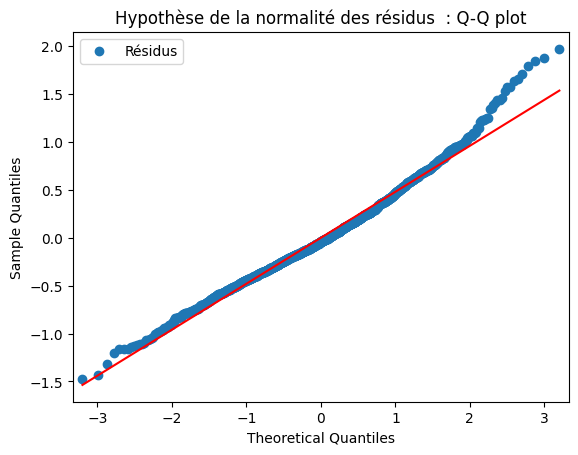

In [20]:
sm.qqplot(reg_multi.resid, line='s', label="Résidus")
plt.title("Hypothèse de la normalité des résidus  : Q-Q plot")
plt.legend()
plt.show()

Il semblerait que nos résidus ne suivent pas une dsitribution normale, vérifions cela a l'aide du test de Shapiro-Wilk :

C:\Users\Armel\AppData\Local\Temp\ipykernel_3528\2817502263.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(reg_multi.resid)


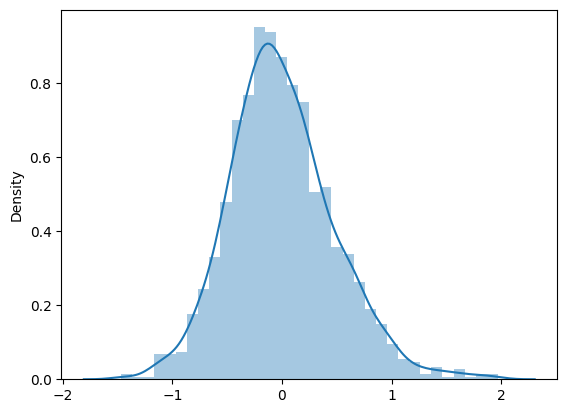

statistique: 0.9857882577573777 p_value: 8.540407842388085e-11


In [21]:
statistic, p_value = shapiro(reg_multi.resid)
sns.distplot(reg_multi.resid)
plt.show()
print("statistique:",statistic,"p_value:",p_value)

Notre p_value etant inférieur a 5% cela confirme l'hypothèse que nos résidus ne suivent pas une distribution normale

##### Homoscédacité des résidus

Nous allons enfin tester l'homoscédasticité ou l'hétéroscédasticité des résidus de notre regression linéaire multiple 

In [22]:
_, pval, __, f_pval = statsmodels.stats.diagnostic.het_breuschpagan(reg_multi.resid, variables)
print('p value test Breusch Pagan:', pval)

p value test Breusch Pagan: 7.7595352161779375e-16


le resultat de notre test de breusch-pagan indique une hétéroscédasticité de nos résidus (p value largement inférieur a 5%).

Puisque les hypothèses de normalité et d'homoscédasticité ne sont pas strictement respectées, nous allons utiliser notre modèle de régression linéaire multiple avec prudence en vérifiant avec attention les résultats produits.

#### Aplication de notre modèle de régression linéaire multiple

Nous allons désormais appliquer notre modèle de regression linéaire multiple a notre jeu de données : 

In [23]:
margin_low_predict = reg_multi.predict(billets)
margin_low_predict=pd.DataFrame(margin_low_predict)
margin_low_predict

,0
0,4.788676
1,4.138908
2,4.125933
3,4.156580
4,4.577425
...,...
1495,5.191741
1496,5.456887
1497,4.900277
1498,4.808574


In [24]:
df_merge=pd.merge(margin_low_predict,billets, left_index=True, right_index=True, how='right')
df_merge.rename(columns={0:'margin_low_pred'}, inplace=True)
df_merge

,margin_low_pred,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,4.788676,True,171.81,104.86,104.95,4.52,2.89,112.83
1,4.138908,True,171.46,103.36,103.66,3.77,2.99,113.09
2,4.125933,True,172.69,104.48,103.50,4.40,2.94,113.16
3,4.156580,True,171.36,103.91,103.94,3.62,3.01,113.51
4,4.577425,True,171.73,104.28,103.46,4.04,3.48,112.54
...,...,...,...,...,...,...,...,...
1495,5.191741,False,171.75,104.38,104.17,4.42,3.09,111.28
1496,5.456887,False,172.19,104.63,104.44,5.27,3.37,110.97
1497,4.900277,False,171.80,104.01,104.12,5.51,3.36,111.95
1498,4.808574,False,172.06,104.28,104.06,5.17,3.46,112.25


on va ensuite remplacer nos valeurs nulles de margin_low par les valeurs prédites par la régression linéaire multiple :

In [25]:
df_merge.loc[df_merge['margin_low'].isna(),'margin_low']=df_merge['margin_low_pred']
billets_cleaned=df_merge.drop('margin_low_pred', axis=1)
billets_cleaned

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54
...,...,...,...,...,...,...,...
1495,False,171.75,104.38,104.17,4.42,3.09,111.28
1496,False,172.19,104.63,104.44,5.27,3.37,110.97
1497,False,171.80,104.01,104.12,5.51,3.36,111.95
1498,False,172.06,104.28,104.06,5.17,3.46,112.25


In [26]:
billets_cleaned.isnull().sum()

is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64

#### Analyse du résultat de la régression linéaire multiple

Afin de nous assurer que la remplacement des valeurs nulles de la colonne margin_low n'a pas altéré la cohérence statistique de nos données nous allons réaliser quatre vérifications : 

- Comparaison des statistiques descriptives 

- Analyse de la corrélation 

- Analyse de la dispersion 

- Comparaison des distribution des vrais et faux billets

##### Comparaison des statistiques descriptives 

In [27]:
billets['margin_low'].describe()

count    1463.000000
mean        4.485967
std         0.663813
min         2.980000
25%         4.015000
50%         4.310000
75%         4.870000
max         6.900000
Name: margin_low, dtype: float64

In [28]:
billets_cleaned['margin_low'].describe()

count    1500.000000
mean        4.483475
std         0.659632
min         2.980000
25%         4.020000
50%         4.310000
75%         4.870000
max         6.900000
Name: margin_low, dtype: float64

Que ce soit en termes de médiane, de moyenne ou de quartiles, les valeurs sont quasiment égales ou très legèrement divergentes entre nos valeurs de margin_low initiales et nos valeurs de margin_low dont les nulls ont été remplacés

##### Analyse de la corrélation

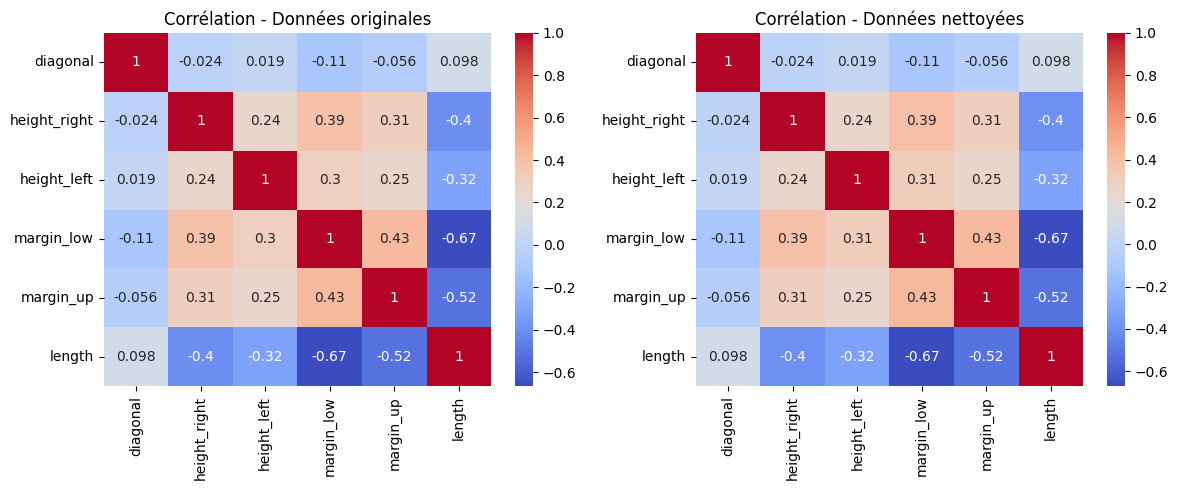

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(billets[['diagonal', 'height_right', 'height_left', 'margin_low', 'margin_up', 'length']].corr(), cmap="coolwarm", annot=True, ax=ax1)
ax1.set_title('Corrélation - Données originales')

sns.heatmap(billets_cleaned[['diagonal', 'height_right', 'height_left', 'margin_low', 'margin_up', 'length']].corr(), cmap="coolwarm", annot=True, ax=ax2)
ax2.set_title('Corrélation - Données nettoyées')

# Afficher les graphiques
plt.tight_layout()
plt.show()

On va confirmer ceci via l'affichage de la plus forte corrélation de notre matrice : entre margin_low et length 

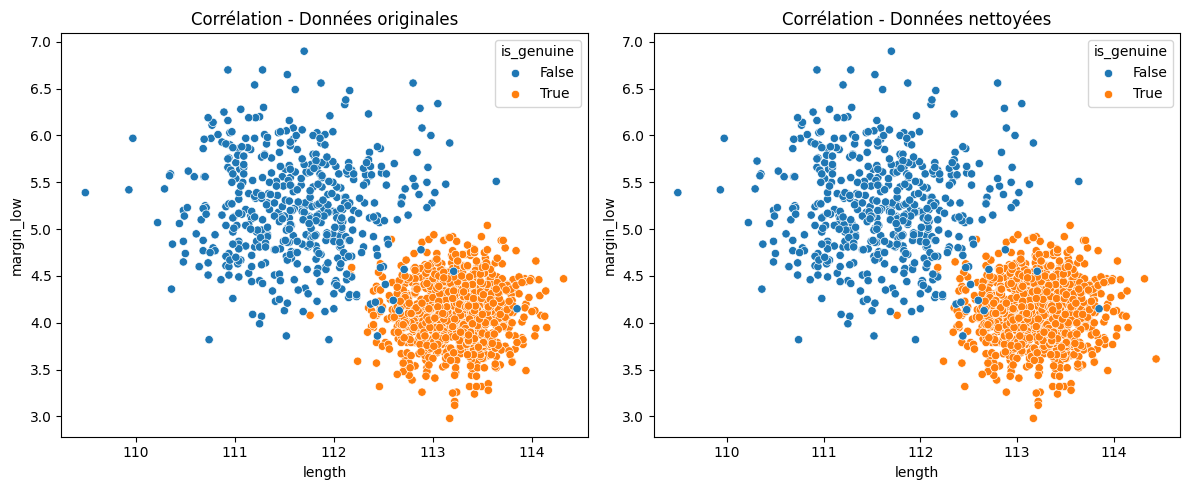

In [30]:
# Création de la grille de sous-graphiques
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

sns.scatterplot(data = billets, y = 'margin_low', x = 'length' , hue='is_genuine',ax=ax1)
ax1.set_title('Corrélation - Données originales')

sns.scatterplot(data = billets_cleaned, y = 'margin_low', x = 'length' , hue='is_genuine',ax=ax2)
ax2.set_title('Corrélation - Données nettoyées')

# Afficher les graphiques
plt.tight_layout()
plt.show()

On constate que la matrice de corrélation de nos variables avant et après nettoyage est exactement la même, il en va de même pour le nuage de point sur nos individus sur les variables margin_low et length. Le remplacement des valeurs n'a donc pas eu d'impact a ce niveau la

##### Analyse de la dispersion

Analysons la dispersion de valeurs de la dimension margin_low en fonction de la nature des billets (vrai ou faux) ainsi que de la source de données (données originales vs données nettoyées)

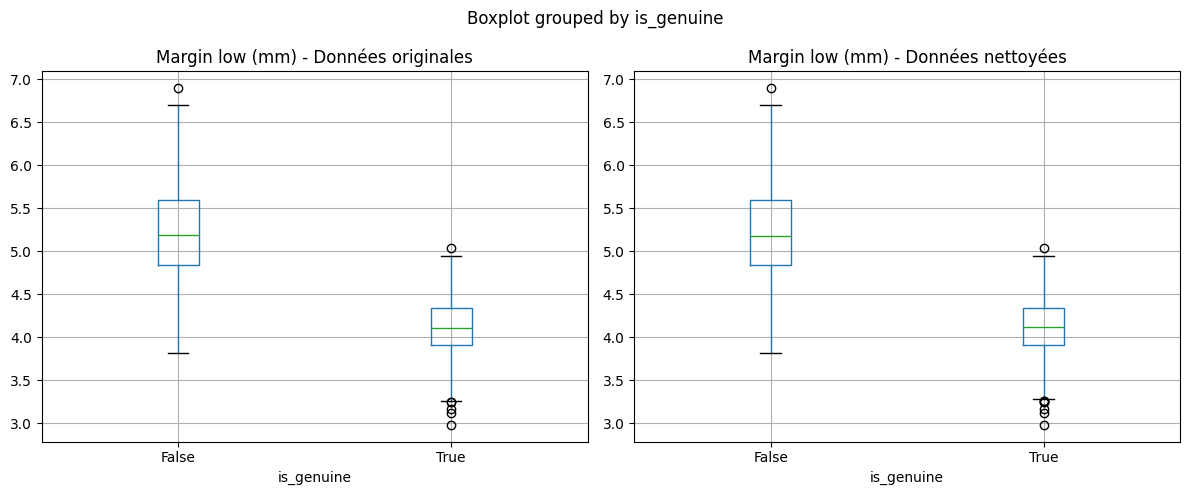

In [31]:
# Création de la grille de sous-graphiques
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

billets.boxplot(column='margin_low',by='is_genuine', ax=ax1)
ax1.set_title('Margin low (mm) - Données originales')


billets_cleaned.boxplot(column='margin_low',by='is_genuine', ax=ax2)
ax2.set_title('Margin low (mm) - Données nettoyées')

# Afficher les graphiques
plt.tight_layout()
plt.show()

Visuellement, la dispersion des valeurs de margin_low, que ce soit concernant les vrais ou les faux billets, n'a pas été altérée par nos modifications

##### Analyse de la distribution


Analyse enfin la distribution de nos individus sur la varibale margin low et en fonction de leur nature de vrai ou faux billet : 

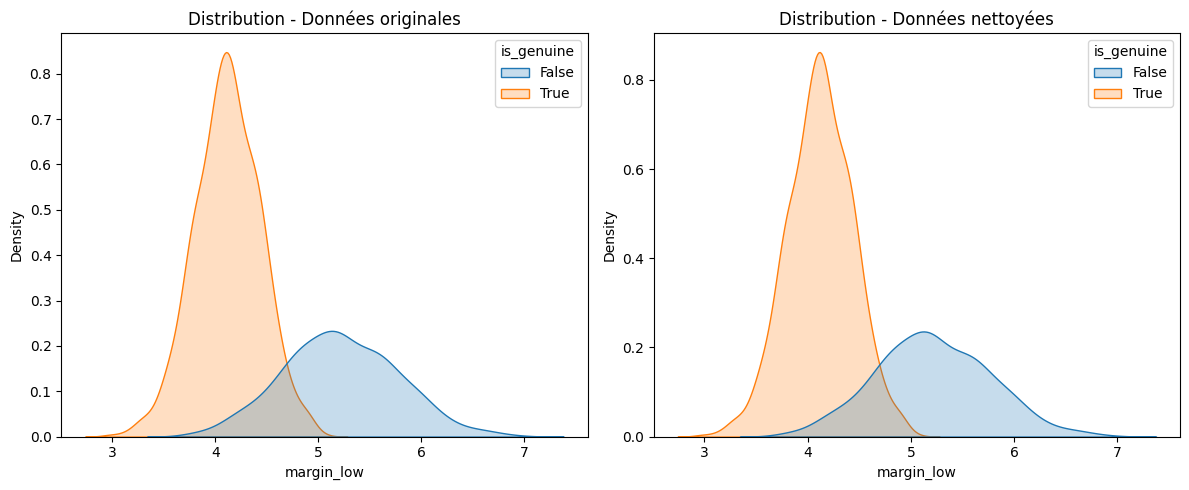

In [32]:
# Création de la grille de sous-graphiques
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

sns.kdeplot(data = billets, x = 'margin_low', hue='is_genuine', fill=True, ax=ax1)
ax1.set_title('Distribution - Données originales')

sns.kdeplot(data = billets_cleaned, x = 'margin_low' ,hue='is_genuine', fill=True, ax=ax2)
ax2.set_title('Distribution - Données nettoyées')

# Afficher les graphiques
plt.tight_layout()
plt.show()

Que ce soit avec les données originales et avec les données dont les nulls ont été comblés a l'aide de la regression linéaire, la distribution reste visuelle la même et exclue donc tout impact statistique majeur

#### Vérification de la significativité statistique de nos deux groupes 

On va vérifier que nos deux groupes (vrais et faux billets) sont toujours bien statistiquement différents même suite au remplacement des valeurs nulles de margin_low via un modèle de regression linéaire multiple.

Afin de savoir quel test utiliser nous allons devoir vérifier deux critères : 

- la normalité des données a l'aide du test de Shapiro Wilk

- l'égalité des variances a l'aide du test de Barlett


Si les données sont normales et les variances égales, ,nous utiliseront le test t de Student.

Si les données ne sont pas normales ou les variances inégales, nous utiliseront le test de Mann-Whitney.

In [33]:
vrai_billets = billets_cleaned[billets_cleaned['is_genuine'] == True]
faux_billets = billets_cleaned[billets_cleaned['is_genuine'] == False]

Nous allons dans un premier temps tester la normalité de la distrubtion des variables de chaque groupes a l'aide du test de Shaprio Wilk : 

In [34]:
normality_results = {}

for col in billets_cleaned.columns:
    if col != 'is_genuine':
        stat_true, p_true = stats.shapiro(vrai_billets[col])
        stat_fake, p_fake = stats.shapiro(faux_billets[col])
        
        normality_results[col] = {'p_value_vrais': p_true, 'p_value_faux': p_fake}
        
        print(f'Test de Shapiro pour la colonne {col} (vrais): stat={stat_true}, p-value={p_true}')
        print(f'Test de Shapiro pour la colonne {col} (faux): stat={stat_fake}, p-value={p_fake}')


Test de Shapiro pour la colonne diagonal (vrais): stat=0.9980672908636019, p-value=0.31196640875121606
Test de Shapiro pour la colonne diagonal (faux): stat=0.9974348748668604, p-value=0.6385168317015244
Test de Shapiro pour la colonne height_left (vrais): stat=0.9965844064548799, p-value=0.02868852105934944
Test de Shapiro pour la colonne height_left (faux): stat=0.9978760420739532, p-value=0.7905021013822957
Test de Shapiro pour la colonne height_right (vrais): stat=0.9985481811753003, p-value=0.5863761785470052
Test de Shapiro pour la colonne height_right (faux): stat=0.9979898161488792, p-value=0.8265215974200968
Test de Shapiro pour la colonne margin_low (vrais): stat=0.9982841992031697, p-value=0.422506874702676
Test de Shapiro pour la colonne margin_low (faux): stat=0.9970298940228189, p-value=0.5008445528168862
Test de Shapiro pour la colonne margin_up (vrais): stat=0.9981576358117173, p-value=0.35504679329562383
Test de Shapiro pour la colonne margin_up (faux): stat=0.99573455

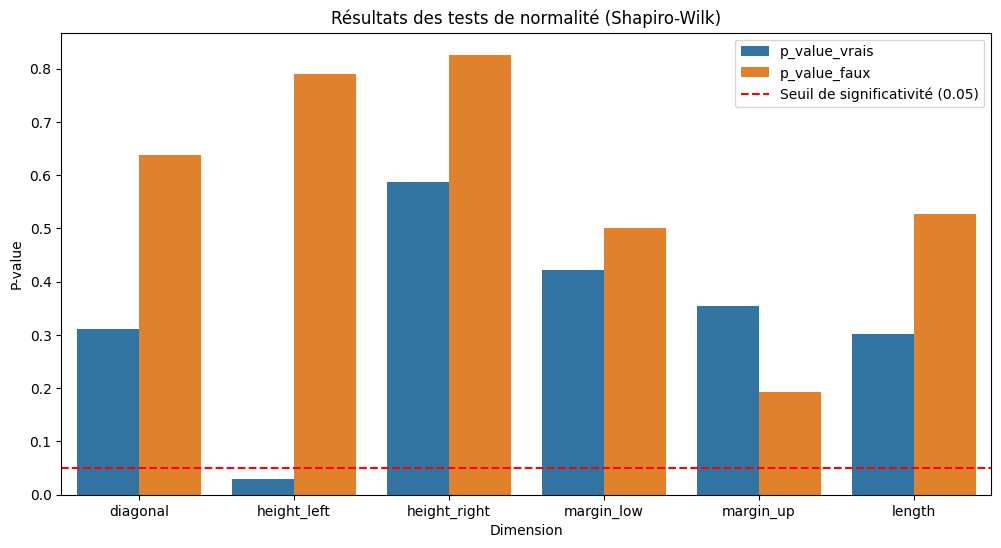

In [35]:
# Préparation des données pour la visualisation
normalite_df = pd.DataFrame(normality_results).T.reset_index().melt(id_vars=['index'])
normalite_df.columns = ['Dimension', 'Type', 'P-value']

# Graphique des résultats des tests de normalité
plt.figure(figsize=(12, 6))
sns.barplot(x='Dimension', y='P-value', hue='Type', data=normalite_df)
plt.axhline(0.05, color='red', linestyle='--', label='Seuil de significativité (0.05)')
plt.title('Résultats des tests de normalité (Shapiro-Wilk)')
plt.legend()
plt.show()


L'ensemble des groupes de billets de nos colonnes présentent une p-value > a 0,05 excepté concernant la caractéristique 'height_left' des vrai billets. 

On peut donc conclure que : 

- Les colonnes diagonal, height_right, margin_low, margin_up, et length suivent une distribution normale pour les vrais et les faux billets.

- La colonne height_left suit une distribution normale pour les faux billets, mais pas pour les vrais billets.

Puisque nous n'avons pas de déviation majeure de la normalité dans les différentes variables analysées, on va réaliser un test de Barltett afin de venir comparer les variance de nos groupes  :

In [36]:
# Initialisation des résultats du test de Bartlett
bartlett_results = {}

# Test de Bartlett pour chaque colonne de caractéristiques
for col in billets_cleaned.columns:
    if col != 'is_genuine':
        stat, p_value = stats.bartlett(vrai_billets[col], faux_billets[col])
        bartlett_results[col] = p_value
        print(f'Test de Bartlett pour la colonne {col}: stat={stat}, p-value={p_value}')


Test de Bartlett pour la colonne diagonal: stat=0.2987117108231198, p-value=0.5846911917441117
Test de Bartlett pour la colonne height_left: stat=53.27625211922919, p-value=2.8978873571016144e-13
Test de Bartlett pour la colonne height_right: stat=3.5425895241258423, p-value=0.059812013905754455
Test de Bartlett pour la colonne margin_low: stat=216.88739037276628, p-value=4.318616798062118e-49
Test de Bartlett pour la colonne margin_up: stat=0.6698400851040492, p-value=0.41310736619275057
Test de Bartlett pour la colonne length: stat=207.23111965352734, p-value=5.520465521421959e-47


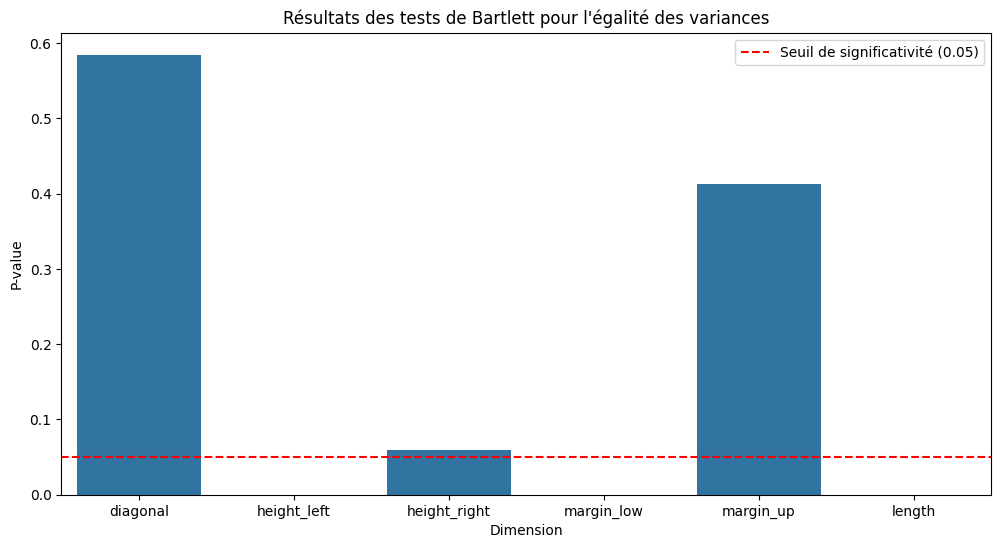

In [37]:
# Préparation des données pour la visualisation
Bartlett_df = pd.DataFrame(list(bartlett_results.items()), columns=['Dimension', 'P-value'])

# Graphique des résultats des tests de Bartlett
plt.figure(figsize=(12, 6))
sns.barplot(x='Dimension', y='P-value', data=Bartlett_df)
plt.axhline(0.05, color='red', linestyle='--', label='Seuil de significativité (0.05)')
plt.title('Résultats des tests de Bartlett pour l\'égalité des variances')
plt.legend()
plt.show()


Le resultat du test de Bartlett sur l'ensemble de nos colonnes est le suivant : 

- Pour les colonnes diagonal, height_right, et margin_up, les variances sont similaires entre les vrais et les faux billets.

- Pour les colonnes height_left, margin_low, et length, les variances sont statistiquement différentes entre les vrais et les faux billets.

on va donc utiliser le test t de student  pour les paramètres diagonal, height_right et margin_up et un test t de Welch pour les paramètres dont la variance est inégale, soit height_left, margin_low et length

In [38]:
student_results = {}

# Liste des colonnes à tester avec le test t classique (Student)
student_columns = ['diagonal', 'height_right', 'margin_up']

for col in billets_cleaned.columns:
    if col in student_columns:
        stat, p_value = stats.ttest_ind(vrai_billets[col], faux_billets[col], equal_var=True)
        student_results[col] = {'stat': stat, 'p_value': p_value}
        print(f'Test t classique (Student) pour la colonne {col}: stat={stat}, p-value={p_value}')

Test t classique (Student) pour la colonne diagonal: stat=5.184087524514633, p-value=2.4668667372034535e-07
Test t classique (Student) pour la colonne height_right: stat=-21.470310019402618, p-value=2.270855690345951e-89
Test t classique (Student) pour la colonne margin_up: stat=-29.50561631725463, p-value=3.144530308715909e-151


In [39]:
welch_results = {}

# Liste des colonnes à tester avec le test t de Welch
welch_columns = ['height_left', 'margin_low', 'length']

for col in billets_cleaned.columns:
    if col in welch_columns:
        stat, p_value = stats.ttest_ind(vrai_billets[col], faux_billets[col], equal_var=False)
        welch_results[col] = {'stat': stat, 'p_value': p_value}
        print(f'Test t de Welch pour la colonne {col}: stat={stat}, p-value={p_value}')

Test t de Welch pour la colonne height_left: stat=-17.48660281591907, p-value=1.415362997565114e-61
Test t de Welch pour la colonne margin_low: stat=-41.22587929536445, p-value=6.548534980340684e-186
Test t de Welch pour la colonne length: stat=52.77360271974255, p-value=1.469954563438362e-241


In [40]:
billets_cleaned.to_csv('billets_cleaned.csv', sep=';')

Les résultats de nos tests, matérialisés par des p-values très faibles (bien inférieures à 0.05) montrent que pour toutes les colonnes testées, il existe des différences significatives entre les vrais et les faux billets. 

Ces résultats indiquent donc que les dimensions des billets peuvent être utilisées pour discriminer efficacement entre les vrais et les faux billets et que nos modifications apportées sur les valeurs manquantes du paramètre margin_low n'ont pas eu d'impact a ce niveau.

### Detection des faux billets

Afin d'assurer le bon fonctionnement de nos données avec les outils de machine learning on va transformer les booléens True et False en entiers : 
- True = 1
- Flase = 0

In [41]:
billets_cleaned['is_genuine'] = billets_cleaned['is_genuine'].astype(int)

Dans un premier temps on va splitter notre dataframe a l'aide de la fonction 'train_test_split' afin d'avoir un dataframe pour entrainer nos modèles et un dataframe pour tester leur efficacité par la suite, la paramètre random_state nous permettre d'itérer sur différent découpages par la suite

In [42]:
# Utilisation de la fonction train_test_split avec le paramètre stratify pour maintenir la proportion de 'is_genuine'
train_df, test_df = train_test_split(billets_cleaned, test_size=0.3, stratify=billets_cleaned['is_genuine'], random_state=1)

# Vérification de la répartition des DF
print(train_df['is_genuine'].value_counts(normalize=True))
print(test_df['is_genuine'].value_counts(normalize=True))

is_genuine
1    0.666667
0    0.333333
Name: proportion, dtype: float64
is_genuine
1    0.666667
0    0.333333
Name: proportion, dtype: float64


In [43]:
print("Nombre d'individus dans le dataframe d'entrainement :",len(train_df),"et dans le dataframe de test :",len(test_df))


Nombre d'individus dans le dataframe d'entrainement : 1050 et dans le dataframe de test : 450


On va ensuite retirer la colonne 'is_genuine' de nos deux df afin de ne pas biaiser nos différents modèles d'aprentissage 

In [44]:
data_train = train_df.drop('is_genuine', axis=1)
label_train = train_df['is_genuine']
data_test = test_df.drop('is_genuine', axis=1)
label_test = test_df['is_genuine']

#### Méthode du K-means

Nous allons tenter d'utiliser l'algorithme de clustering K-means afin de séparer en deux groupes nos vrais et nos faux billets

On va dans un premier temps determiner le nombre de clusters a produire grace a la méthode du coude : 

In [45]:
intertia_list = [ ]

k_list = range(1, 10)

for k in k_list : 
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(data_train)
    intertia_list.append(kmeans.inertia_)

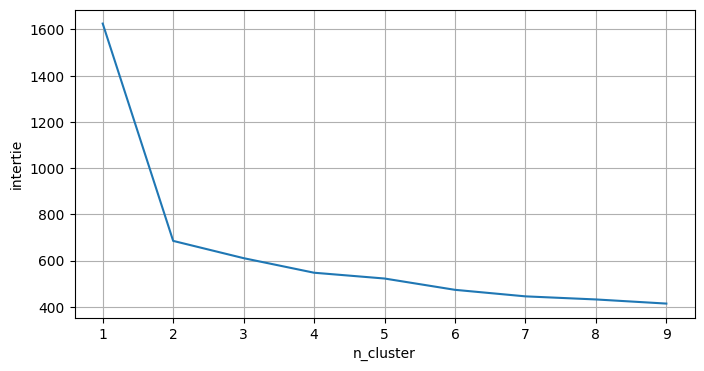

In [46]:
fig, ax = plt.subplots(1,1,figsize=(8,4))
ax.set_ylabel("intertie")
ax.set_xlabel("n_cluster")
ax = plt.plot(k_list, intertia_list)
plt.grid()
plt.show()

On va donc tabler sur deux clusters comme l'indique la cassure sur notre courbe

Dans un premier temps nous allons créer une matrice de normalisation a l'aide de nos données d'entrainement que nous appliqueront ensuite sur nos données de test afin de respecter ue continuité suite à l'entrainement de notre modèle !

In [47]:
# Standardisation des données d'entraînement
scaler = StandardScaler()
data_train_scaled = scaler.fit_transform(data_train)

On va ensuite entrainer notre modèle Kmeans sur nos données d'entrainement normalisées : 

In [48]:
# # Entraînement du modèle KMeans
n_clust = 2
kmeans = KMeans(n_clusters=n_clust)
kmeans.fit(data_train_scaled)

KMeans(n_clusters=2)

Puis on va enregistrer notre modèle entrainé afin de pouvoir le réutiliser par la suite :

In [49]:
# Enregistrement du modèle KMeans et du scaler
joblib.dump(kmeans, 'kmeans_model.joblib')
joblib.dump(scaler, 'scaler.joblib')

['scaler.joblib']

On charge donc notre modèle précédemment entrainé 

In [50]:
# Charger le modèle KMeans et le scaler
kmeans_loaded = joblib.load('kmeans_model.joblib')
scaler_loaded = joblib.load('scaler.joblib')

On applique notre matrice de normalisation a nos données de test pour reproduire le même paramétrage que lors de l'entrainement de notre modèle pour assurer la meilleur précision possible

In [58]:
# Standardisation des données de test
data_test_scaled = scaler_loaded.transform(data_test)

Puis on applique notre modèle de Kmeans entrainé sur nos données de test normalisées 

In [59]:
test_clusters = kmeans_loaded.predict(data_test_scaled)

On va ensuite rattacher les prédictions du modèle a notre dataframe de test avec lable afin de comparer les performances du modèle a la réalité :

In [60]:
kmeans_df = test_df.copy()
kmeans_df['cluster'] = test_clusters
kmeans_df

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,cluster
1440,0,171.53,104.41,103.85,4.64,3.39,111.94,1
265,1,172.15,104.02,103.94,3.96,2.87,112.38,0
1071,0,171.50,103.90,103.98,4.82,3.40,112.07,1
1022,0,172.89,104.03,104.03,6.03,3.00,110.95,1
307,1,172.24,104.22,103.67,4.30,3.33,113.13,0
...,...,...,...,...,...,...,...,...
588,1,171.92,103.67,104.24,4.11,3.09,113.23,0
894,1,172.02,103.67,104.22,4.40,3.04,113.33,0
1262,0,171.93,104.43,104.15,5.80,3.40,111.82,1
1319,0,171.74,104.40,104.39,4.87,3.06,112.00,1


Les clusters sont inversés vis a vis de notre label is genuine, on va donc les modifier afin qu'ils correspondent :  

In [61]:
cluster_to_class = {0: 1, 1: 0}
kmeans_predictions = np.array([cluster_to_class[cluster] for cluster in test_clusters])
kmeans_predictions

array([0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0,
       0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0,

Puis on vient analyser les resultats de la prédiction a l'aide de plusieurs outils : 

- la matrice de confusion
- le score de prédiction 
- le rapport de classification

Précision du Kmeans: 0.98
Rapport de classification Kmeans:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97       150
           1       0.98      0.99      0.99       300

    accuracy                           0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450

Matrice de confusion:
 [[145   5]
 [  4 296]]


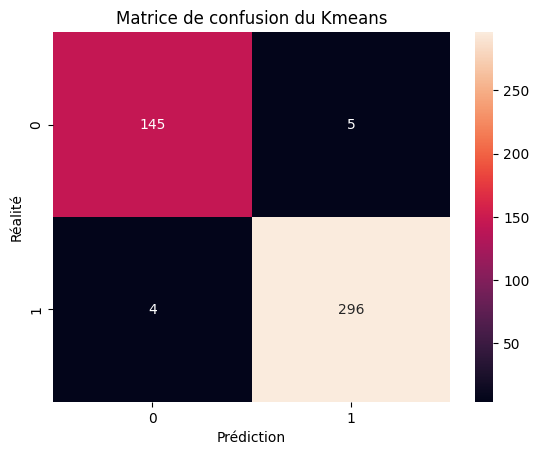

In [62]:
# Précision
print("Précision du Kmeans:", accuracy_score(label_test, kmeans_predictions))

# Rapport de classification
print("Rapport de classification Kmeans:\n", classification_report(label_test, kmeans_predictions))

# Matrice de confusion
conf_matrix = confusion_matrix(label_test, kmeans_predictions)
print("Matrice de confusion:\n", conf_matrix)

# Viz de la matrice de confusion
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Prédiction')
plt.ylabel('Réalité')
plt.title('Matrice de confusion du Kmeans')
plt.show()

In [63]:
print('La méthode du Kmeans permet de classifier correctement les billets dans environ', accuracy_score(label_test, kmeans_predictions)*100,"% des cas avec comme résultat sur notre batch de test :")

print("-", conf_matrix[1,1],"vrais positifs (vrais billets décelés comme vrais par l'algorithme)")
print("-", conf_matrix[1,0],"vrais négatifs (vrais billets décelés comme faux par l'algorithme)")
print("-", conf_matrix[0,0], "faux positifs (faux billets décelés comme faux par l'algorithme)")
print("-", conf_matrix[0,1],"faux négatifs (faux billets décelés comme vrais par l'algorithme)")

print("Soit un total de",conf_matrix[1,0] + conf_matrix[0,1],"erreurs de détection et",conf_matrix[1,1]+conf_matrix[0,0],"succès")

La méthode du Kmeans permet de classifier correctement les billets dans environ 98.0 % des cas avec comme résultat sur notre batch de test :
- 296 vrais positifs (vrais billets décelés comme vrais par l'algorithme)
- 4 vrais négatifs (vrais billets décelés comme faux par l'algorithme)
- 145 faux positifs (faux billets décelés comme faux par l'algorithme)
- 5 faux négatifs (faux billets décelés comme vrais par l'algorithme)
Soit un total de 9 erreurs de détection et 441 succès


##### Réalisation d'une ACP

Afin de mieux visualiser les clusters produits par notre modèle, nous allons réaliser une ACP puis projeter nos individus du df 'test' sur nos nouvelles composantes

1. réalisation du graphique de corrélation

In [64]:
n_components = 4
pca = PCA(n_components=n_components)
pca.fit(data_train_scaled)


PCA(n_components=4)

In [65]:
features = data_test.columns
features

Index(['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up',
       'length'],
      dtype='object')

In [66]:
def correlation_graph(pca, 
                      x_y, 
                      features) : 
    """Affiche le graphe des correlations

    Positional arguments : 
    -----------------------------------
    pca : sklearn.decomposition.PCA : notre objet PCA qui a été fit
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2
    features : list ou tuple : la liste des features (ie des dimensions) à représenter
    """

    # Extrait x et y 
    x,y=x_y

    # Taille de l'image (en inches)
    fig, ax = plt.subplots(figsize=(8, 6))

    # Pour chaque composante : 
    for i in range(0, pca.components_.shape[1]):

        # Les flèches
        ax.arrow(0,0, 
                pca.components_[x, i],  
                pca.components_[y, i],  
                head_width=0.07,
                head_length=0.07, 
                width=0.02, )

        # Les labels
        plt.text(pca.components_[x, i] + 0.05,
                pca.components_[y, i] + 0.05,
                features[i])
        
    # Affichage des lignes horizontales et verticales
    plt.plot([-1, 1], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-1, 1], color='grey', ls='--')

    # Nom des axes, avec le pourcentage d'inertie expliqué
    plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
    plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

    # J'ai copié collé le code sans le lire
    plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))

    # Le cercle 
    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale

    # Axes et display
    plt.axis('equal')
    plt.show(block=False)

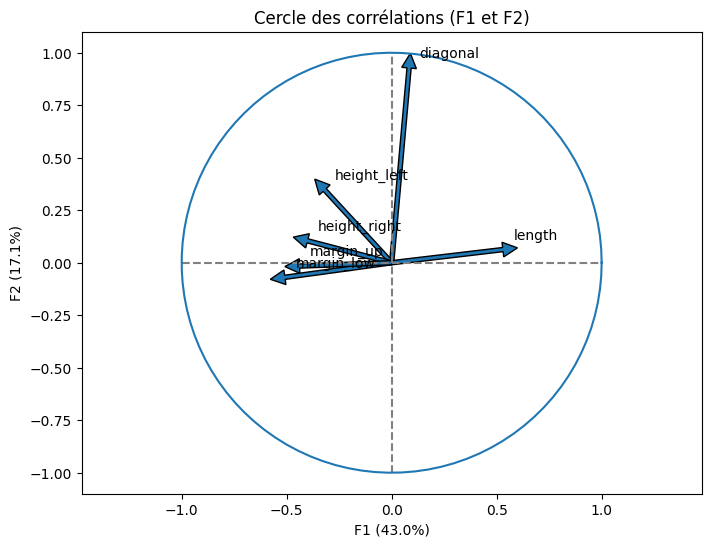

In [67]:
correlation_graph(pca, (0,1), features)

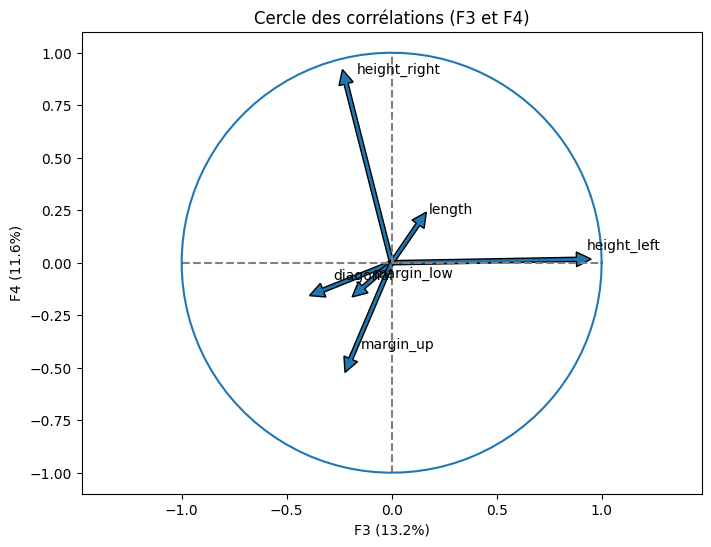

In [68]:
correlation_graph(pca, (2,3), features)

On constate que les quatre composantes principales issues de notre ACP comportent quasiment 85% de l'inertie, dont 43% de l'inertie portée par notre variable F1 a elle seule ! 

2. projection des individus de notre DF Test

In [69]:
x_y = (0,1)
X_proj = pca.transform(data_test_scaled)
X_proj[:5]

array([[-1.4469268 , -0.95484771,  1.27592796, -0.59559113],
       [ 0.78518221,  0.62481099,  0.05179917,  0.5953024 ],
       [-1.15220441, -1.60174722, -0.3021554 , -0.28827088],
       [-1.8263594 ,  2.56328641, -1.49629133, -0.39692077],
       [ 0.26597864,  1.02575718,  0.38028921, -0.95715265]])

In [70]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def display_factorial_planes(X_projected, 
                             x_y, 
                             pca=None, 
                             labels=None,
                             clusters=None, 
                             alpha=1,
                             figsize=[8,6], 
                             marker="."):

    # Transforme X_projected en np.array
    X_ = np.array(X_projected)

    # On définit la forme de la figure si elle n'a pas été donnée
    if not figsize: 
        figsize = (7,6)

    # On gère les labels
    if labels is None: 
        labels = []
    try: 
        len(labels)
    except Exception as e: 
        raise e

    # On vérifie la variable axis 
    if not len(x_y) == 2: 
        raise AttributeError("2 axes sont demandées")   
    if max(x_y) >= X_.shape[1]: 
        raise AttributeError("la variable axis n'est pas bonne")   

    # On définit x et y 
    x, y = x_y

    # Initialisation de la figure       
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    # On vérifie s'il y a des clusters ou non
    c = None if clusters is None else clusters
 
    # Les points    
    sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], s=70,hue=c, alpha=alpha, marker=marker)

    # Si la variable pca a été fournie, on peut calculer le % de variance de chaque axe 
    if pca: 
        v1 = str(round(100 * pca.explained_variance_ratio_[x])) + " %"
        v2 = str(round(100 * pca.explained_variance_ratio_[y])) + " %"
    else: 
        v1 = v2 = ''

    # Nom des axes, avec le pourcentage d'inertie expliqué
    ax.set_xlabel(f'F{x+1} {v1}')
    ax.set_ylabel(f'F{y+1} {v2}')

    # Valeur x max et y max
    x_max = np.abs(X_[:, x]).max() * 1.1
    y_max = np.abs(X_[:, y]).max() * 1.1

    # On borne x et y 
    ax.set_xlim(left=-x_max, right=x_max)
    ax.set_ylim(bottom=-y_max, top=y_max)

    # Affichage des lignes horizontales et verticales
    plt.plot([-x_max, x_max], [0, 0], color='grey', alpha=0.8)
    plt.plot([0, 0], [-y_max, y_max], color='grey', alpha=0.8)

    # Affichage des labels des points
    if len(labels): 
        for i, (_x, _y) in enumerate(X_[:, [x, y]]):
            plt.text(_x, _y + 0.05, labels[i], fontsize='14', ha='center', va='center')

    # Calcul et affichage des centroïdes des clusters
    if clusters is not None:
        unique_clusters = np.unique(clusters)
        for cluster in unique_clusters:
            cluster_points = X_[clusters == cluster]
            centroid_x = np.mean(cluster_points[:, x])
            centroid_y = np.mean(cluster_points[:, y])
            plt.scatter(centroid_x, centroid_y, marker='^', s=50, color='red')

    # Titre et display
    plt.title(f"Projection des individus (sur F{x+1} et F{y+1})")
    plt.show()


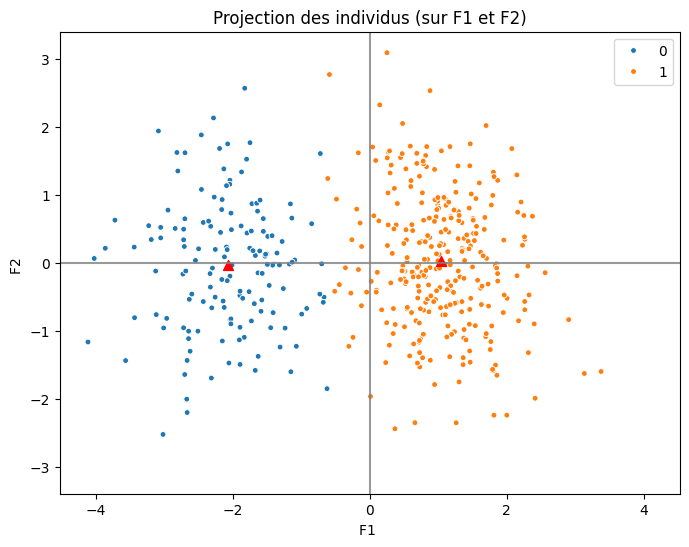

In [71]:
x_y = [0,1]
display_factorial_planes(X_proj, x_y, clusters=kmeans_predictions)

On constate que notre cluster de vrais billets (1) est très fortement corrélé positivement à notre composante principale F1 elle même fortement corrélé positivement à la longueur des billets, alors que notre cluster de faux billets est lui exclusivement corrélé négativement à F1, soit aux variables de marge et de hauteur.


#### Méthode de la régression logistique

Nous allons désormais tester de prédire la nature de nos billets a l'aide de la regression logistique : 

In [72]:
train_df

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
120,1,171.92,103.78,103.61,4.020000,3.31,112.91
257,1,172.19,104.03,104.25,4.170000,2.81,112.94
1298,0,172.00,104.36,104.16,4.940000,3.25,111.82
1048,0,172.16,104.24,104.47,6.080000,3.49,111.59
902,1,171.50,104.27,104.04,3.970000,3.37,112.98
...,...,...,...,...,...,...,...
772,1,172.12,103.95,104.08,4.500000,3.06,113.18
871,1,171.37,104.07,103.75,4.249629,3.07,113.27
1116,0,172.26,103.90,104.12,4.990000,3.42,111.27
1013,0,171.98,104.18,103.59,5.440000,3.39,112.07


Dans un premier temps nous allons vérifier que toutes nos dimensions présentent bien une significativité statistique sur la labelisation des billets : 

In [73]:
reg_log1 = smf.glm('is_genuine~diagonal+height_left+height_right+margin_low+margin_up+length', data=train_df,family=sm.families.Binomial()).fit()
print(reg_log1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             is_genuine   No. Observations:                 1050
Model:                            GLM   Df Residuals:                     1043
Model Family:                Binomial   Df Model:                            6
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -28.391
Date:                Sun, 21 Jul 2024   Deviance:                       56.783
Time:                        19:40:05   Pearson chi2:                 2.44e+03
No. Iterations:                    10   Pseudo R-squ. (CS):             0.7045
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     -161.0678    294.595     -0.547   

Plusieurs paramètres ont une valeur p inférieure à 5 %, ce qui indique une absence de significativité statistique dans la détection des vrais et faux billets. Nous allons donc les retirer un par un, en commençant par le paramètre le moins significatif : la diagonale

In [74]:
reg_log1 = smf.glm('is_genuine~height_left+height_right+margin_low+margin_up+length', data=train_df,family=sm.families.Binomial()).fit()
print(reg_log1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             is_genuine   No. Observations:                 1050
Model:                            GLM   Df Residuals:                     1044
Model Family:                Binomial   Df Model:                            5
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -28.394
Date:                Sun, 21 Jul 2024   Deviance:                       56.789
Time:                        19:40:05   Pearson chi2:                 2.40e+03
No. Iterations:                    10   Pseudo R-squ. (CS):             0.7045
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     -175.7813    220.935     -0.796   

on va ensuite retirer la variable "height_left"

In [75]:
reg_log1 = smf.glm('is_genuine~height_right+margin_low+margin_up+length', data=train_df,family=sm.families.Binomial()).fit()
print(reg_log1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             is_genuine   No. Observations:                 1050
Model:                            GLM   Df Residuals:                     1045
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -28.499
Date:                Sun, 21 Jul 2024   Deviance:                       56.998
Time:                        19:40:05   Pearson chi2:                 2.80e+03
No. Iterations:                    10   Pseudo R-squ. (CS):             0.7044
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     -229.1272    187.530     -1.222   

In [76]:
# # Enregistrement du modèle avec joblib
# joblib.dump(reg_log1, 'reg_log1_model.joblib')
# Chargement du modèle avec joblib
reg_log1_loaded = joblib.load('reg_log1_model.joblib')

On a désormais uniquement des dimensions significativement corrélées au label 'is_genuine', on va pouvoir faire tourner le modèle afin de le tester sur notre batch de billets :

Précision: 0.9866666666666667
Matrice de confusion:
 [[146   4]
 [  2 298]]
Rapport de classification:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98       150
           1       0.99      0.99      0.99       300

    accuracy                           0.99       450
   macro avg       0.99      0.98      0.98       450
weighted avg       0.99      0.99      0.99       450



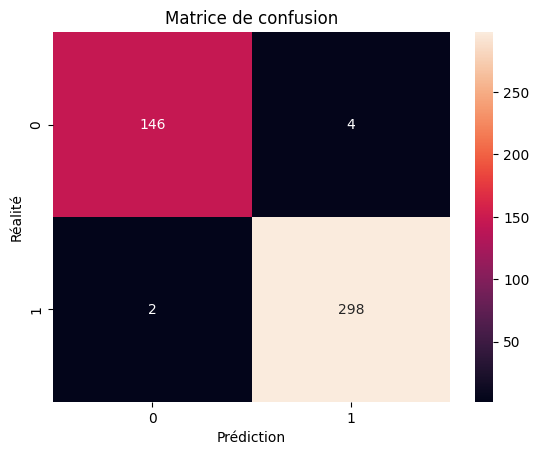

In [77]:
# Prédiction sur les données de test
y_pred_proba = reg_log1_loaded.predict(test_df)
y_pred = (y_pred_proba >= 0.5).astype(int)  # Seuil de 0.5 pour la classification binaire
y_pred_df = pd.DataFrame(y_pred, columns=['prédiction'])

# Stockage de la matrice de confusion et de la précision
conf_matrix_reglog = confusion_matrix(label_test, y_pred)
reglog_accuracy = accuracy_score(label_test, y_pred)

# Évaluation du modèle
print("Précision:", reglog_accuracy)
print("Matrice de confusion:\n", conf_matrix_reglog)
print("Rapport de classification:\n", classification_report(label_test, y_pred))

sns.heatmap(conf_matrix_reglog, annot=True, fmt='d')
plt.xlabel('Prédiction')
plt.ylabel('Réalité')
plt.title('Matrice de confusion')
plt.show()


In [78]:
print('La méthode de la régression logistique permet de classifier correctement les billets dans environ', reglog_accuracy*100,"% des cas avec comme résultat sur notre batch de test :")

print("-", conf_matrix_reglog[1,1],"vrais positifs (vrais billets décelés comme vrais par l'algorithme)")
print("-", conf_matrix_reglog[1,0],"vrais négatifs (vrais billets décelés comme faux par l'algorithme)")
print("-", conf_matrix_reglog[0,0], "faux positifs (faux billets décelés comme faux par l'algorithme)")
print("-", conf_matrix_reglog[0,1],"faux négatifs (faux billets décelés comme vrais par l'algorithme)")

print("Soit un total de",conf_matrix_reglog[1,0] + conf_matrix_reglog[0,1],"erreurs de détection et",conf_matrix_reglog[1,1]+conf_matrix_reglog[0,0],"succès")

La méthode de la régression logistique permet de classifier correctement les billets dans environ 98.66666666666667 % des cas avec comme résultat sur notre batch de test :
- 298 vrais positifs (vrais billets décelés comme vrais par l'algorithme)
- 2 vrais négatifs (vrais billets décelés comme faux par l'algorithme)
- 146 faux positifs (faux billets décelés comme faux par l'algorithme)
- 4 faux négatifs (faux billets décelés comme vrais par l'algorithme)
Soit un total de 6 erreurs de détection et 444 succès


On va également ajouter a notre dataframe la notion de fiabilité, obtenue par la prédiction du modèle pour chaque billet ramené en pourcentage et en respectant le seuile de 0,5 puisque nous sommes sur une classification binaire : 

In [79]:
Resultat = pd.merge(test_df, y_pred_df, left_index=True, right_index=True)
Resultat['fiabilité'] = np.where(y_pred == 1, round(y_pred_proba,3), round(1 - y_pred_proba,3)) * 100
Resultat.sort_values(by='fiabilité')


,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,prédiction,fiabilité
38,1,172.00,103.76,104.27,4.42,3.29,112.67,1,51.2
1281,0,171.62,104.53,103.64,4.89,3.16,112.54,0,54.9
1383,0,171.75,104.16,104.16,4.23,2.99,111.83,0,55.4
626,1,171.98,104.44,104.08,4.67,3.21,112.73,1,56.7
1083,0,171.85,103.60,103.82,4.60,3.21,112.50,1,57.3
...,...,...,...,...,...,...,...,...,...
1072,0,171.41,104.06,104.42,5.04,3.40,111.02,0,100.0
998,1,171.44,103.96,103.92,3.68,2.89,113.21,1,100.0
662,1,171.83,103.76,103.76,4.40,2.88,113.84,1,100.0
771,1,172.10,104.30,103.74,3.85,2.76,113.10,1,100.0


#### Comparaison de la peformance des deux modèles

Afin de mettre en compétition la performance des deux modèles, on va les tester a plusieurs reprises et ce avec une composition différente de nos jeux de test : 

In [80]:
def compare_models(data, n_iterations=5, test_size=0.3, seeds=None):
    kmeans_accuracies = []
    logreg_accuracies = []
    
    if seeds is None:
        # Seeding random si aucune liste de seeding donnée
        seeds = np.random.randint(0, 10000, size=n_iterations)
    else:
        if len(seeds) != n_iterations:
            raise ValueError(f"Le nombre de seeds données ({len(seeds)}) de correspond pas au nombre d'itérations ({n_iterations})")
    
    for i in range(n_iterations):
        random_state = seeds[i]
        
        train_df_comp, test_df_comp = train_test_split(data, test_size=test_size, stratify=data['is_genuine'], random_state=random_state)
        
        data_test_comp = test_df_comp.drop('is_genuine', axis=1)
        label_test_comp = test_df_comp['is_genuine']
        
        # Prédiction avec le kmeans
        data_test_scaled = scaler_loaded.transform(data_test_comp)
        test_clusters = kmeans_loaded.predict(data_test_scaled)
        cluster_to_class = {0: 1, 1: 0}
        kmeans_predictions = np.array([cluster_to_class[cluster] for cluster in test_clusters])
        kmeans_accuracy = accuracy_score(label_test_comp, kmeans_predictions)
        kmeans_accuracies.append(kmeans_accuracy)
        
        # Prediction avec la régression logistique
        y_pred_reglog = reg_log1_loaded.predict(data_test_comp)
        y_pred = (y_pred_reglog >= 0.5).astype(int)
        logreg_accuracy = accuracy_score(label_test_comp, y_pred)
        logreg_accuracies.append(logreg_accuracy)
        
        # affichage des niveaux de précision : 
        print(f"Itération {i+1} avec le seed {random_state}")
        print(f"Précision du KMeans : {round(kmeans_accuracy * 100, 3)}%")
        print(f"Précision de la régression logistique : {round(logreg_accuracy * 100, 3)}%\n")
    
    # Affichage de la précision moyenne par modèle : 
    return {
        'kmeans_accuracy_mean': np.mean(kmeans_accuracies) * 100,
        'logreg_accuracy_mean': np.mean(logreg_accuracies) * 100
    }

# Utilisation de la fonction avec des seeds spécifiques
specified_seeds = [7271,6236,9975,269,3232]
results = compare_models(billets_cleaned, n_iterations=5, seeds=specified_seeds)

print("Moyenne des résultats : ")
print("Moyenne de la précision du KMeans: ", round(results['kmeans_accuracy_mean'], 3), "%")
print("Moyenne de la précision de la régression logistique :", round(results['logreg_accuracy_mean'], 3), "%")


Itération 1 avec le seed 7271
Précision du KMeans : 98.444%
Précision de la régression logistique : 99.333%

Itération 2 avec le seed 6236
Précision du KMeans : 98.444%
Précision de la régression logistique : 99.333%

Itération 3 avec le seed 9975
Précision du KMeans : 98.667%
Précision de la régression logistique : 99.556%

Itération 4 avec le seed 269
Précision du KMeans : 98.0%
Précision de la régression logistique : 98.889%

Itération 5 avec le seed 3232
Précision du KMeans : 98.222%
Précision de la régression logistique : 98.889%

Moyenne des résultats : 
Moyenne de la précision du KMeans:  98.356 %
Moyenne de la précision de la régression logistique : 99.2 %


La regression logistique étant constamment plus précise à chacunes de nos itérations, nous allons donc choisir cette méthode la afin de construire notre module de detection de faux billets

### Outil de detection des faux billets

In [81]:
df_examen = pd.read_csv('billets_production.csv', sep=',')

In [82]:
df_examen.head()

,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5


In [83]:
# Prédire avec le modèle de régression logistique
prediction_proba = reg_log1_loaded.predict(df_examen)
prediction_seuil = (prediction_proba >= 0.5).astype(int)
prediction_seuil = pd.DataFrame(prediction_seuil)

In [84]:
Resultat = pd.merge(df_examen, prediction_seuil, left_index=True, right_index=True)
Resultat.rename(columns={0:'Prédiction'}, inplace=True)
Resultat['Prédiction'] = Resultat['Prédiction'].replace({1:'Vrai billet',0:'Faux billet'})
Resultat

,diagonal,height_left,height_right,margin_low,margin_up,length,id,Prédiction
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1,Faux billet
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2,Faux billet
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3,Faux billet
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4,Vrai billet
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5,Vrai billet


In [85]:
resultat_par_type = Resultat.groupby(Resultat['Prédiction'])['diagonal'].count()
resultat_par_type

Prédiction
Faux billet    3
Vrai billet    2
Name: diagonal, dtype: int64